In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [3]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='vXXGynTxZNarYmfuh0jq8rU90ySFoS4GVUn0revJmnW-',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'flightdelayprediction-donotdelete-pr-dmzogqyqnzufgu'
object_key = 'flightdata.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [28]:
data.shape

(11231, 26)

In [29]:
data.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [30]:
data=data.drop('Unnamed: 25',axis=1)

In [31]:
data['DEST'].unique()

array(['SEA', 'MSP', 'DTW', 'ATL', 'JFK'], dtype=object)

<AxesSubplot:xlabel='ARR_DELAY', ylabel='ARR_DEL15'>

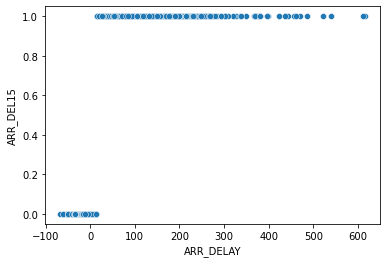

In [32]:
sns.scatterplot(x='ARR_DELAY',y='ARR_DEL15',data=data)

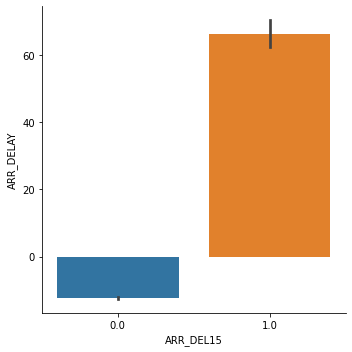

In [33]:
sns.catplot(x='ARR_DEL15',y='ARR_DELAY',kind='bar',data=data)

<AxesSubplot:>

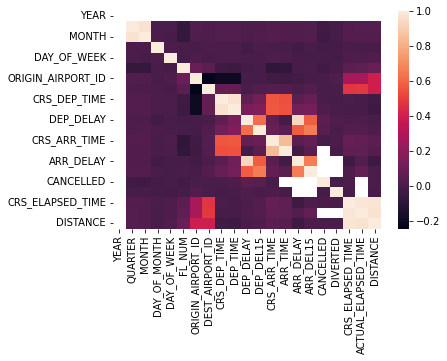

In [34]:
sns.heatmap(data.corr())

In [37]:
datas=data[["MONTH","DAY_OF_MONTH","DAY_OF_WEEK","FL_NUM","ORIGIN","DEST","DEP_DEL15","CRS_ARR_TIME","ARR_DEL15"]]
datas.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
FL_NUM            0
ORIGIN            0
DEST              0
DEP_DEL15       107
CRS_ARR_TIME      0
ARR_DEL15       188
dtype: int64

In [44]:
datas=datas.fillna({'ARR_DEL15':1})
datas=datas.fillna({'DEP_DEL15':0})
datas.iloc[177:185]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,ORIGIN,DEST,DEP_DEL15,CRS_ARR_TIME,ARR_DEL15
177,1,9,6,2834,MSP,SEA,0.0,852,1.0
178,1,9,6,2839,DTW,JFK,0.0,1724,0.0
179,1,10,7,86,MSP,DTW,0.0,1632,1.0
180,1,10,7,87,DTW,MSP,1.0,1649,0.0
181,1,10,7,423,JFK,ATL,0.0,1600,0.0
182,1,10,7,440,JFK,ATL,0.0,849,0.0
183,1,10,7,485,JFK,SEA,1.0,1945,0.0
184,1,10,7,557,MSP,DTW,0.0,912,1.0


In [55]:
x=datas.iloc[:,0:8].values
y=datas.iloc[:,8:9].values

In [56]:
from sklearn.preprocessing import OneHotEncoder
s=OneHotEncoder()
z=s.fit_transform(x[:,4:5]).toarray()
a=s.fit_transform(x[:,5:6]).toarray()

In [65]:
data=pd.get_dummies(datas)

In [58]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [61]:
def func(x,y):
    x_train,x_test,y_train,y_test= train_test_split(x,y,train_size = 0.8, test_size = 0.2,random_state =42)
    rmse=[]
    S=[]
    #Linear regression
    model=LinearRegression().fit(x_train,y_train)
    y_predicted1=model.predict(x_test)
    S.append(model.score(x_test,y_test))
    rmse.append(mean_squared_error(y_test,y_predicted1,squared=False))
    #DecisionTreeRegression
    model1=DecisionTreeRegressor().fit(x_train,y_train)
    y_predicted2=model1.predict(x_test)
    S.append(model1.score(x_test,y_test))
    rmse.append(mean_squared_error(y_test,y_predicted2,squared=False))
    #RandomForestRegressor
    model2=RandomForestRegressor(n_estimators=100,max_depth=2).fit(x_train,y_train)
    y_predicted3=model2.predict(x_test)
    S.append(model2.score(x_test,y_test))
    rmse.append(mean_squared_error(y_test,y_predicted3,squared=False))
    #GradientBoostingRegressor
    model3=GradientBoostingRegressor(n_estimators=100,max_depth=2).fit(x_train,y_train)
    y_predicted4=model3.predict(x_test)
    S.append(model3.score(x_test,y_test))
    rmse.append(mean_squared_error(y_test,y_predicted4,squared=False))
    #AdaBoostRegressor
    model4 = AdaBoostRegressor().fit(x_train,y_train)
    y_predicted5=model4.predict(x_test)
    S.append(model4.score(x_test,y_test))
    rmse.append(mean_squared_error(y_test,y_predicted5,squared=False))
    # XGBoost model
    model5 = XGBRegressor().fit(x_train, y_train)
    y_predicted6=model5.predict(x_test)
    S.append(model5.score(x_test,y_test))
    rmse.append(mean_squared_error(y_test,y_predicted6,squared=False))
    print("score=",S)
    return rmse
result=[]
name=['LINEAR REGRESSION', 'DECISION TREE REGRESSION', 'RANDOM FOREST REGRESSION', 'GRADIENT BOOSTING REGRESSION', 'ADABOOST REGRESSION','XGBOOST']
result=func(x,y)
print(result)
print('\033[1m',name[result.index(min(result))],"is the best fit model with a RMSE of ",min(result),'\033[0m')

C:\Users\HP\AppData\Local\Temp/ipykernel_10828/3963679643.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model2=RandomForestRegressor(n_estimators=100,max_depth=2).fit(x_train,y_train)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


score= [0.0975436142929832, 0.9164493372414164, 0.11637008718049091, 0.38058872376741215, 0.13427997256567226, 0.9422586963883711]
[0.3733667369586676, 0.11360500437149126, 0.3694517412459553, 0.3093228954433737, 0.36568845143160655, 0.09444214]
 XGBOOST is the best fit model with a RMSE of  0.09444214 


In [62]:
model5 =XGBRegressor().fit(x_train, y_train)
y_predicted6=model5.predict(x_test)
#S.append(model5.score(x_test,y_test)
rmse=mean_squared_error(y_test,y_predicted6,squared=False)

In [63]:
print(rmse)

0.095009595


In [64]:
model5.score(x_test,y_test)

0.9425780226681219

In [4]:
print("wasim")

wasim
